In [12]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import pickle
import sklearn
import time
from sklearn import metrics
from sklearn import model_selection
from tensorflow.keras import utils

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [13]:
# omogucava da se koriste funkcije iz sveske SharedFunctions

%run SharedFunctions.ipynb

Učitava se prethodno pripremljen skup podataka: 

In [14]:
data = pd.read_csv('data/data_longer.csv')
data.drop(columns=['Unnamed: 0'], inplace=True)

In [15]:
data.shape

(223453, 9)

In [16]:
# data.head()

### 1. Podela na trening, test, i validacioni skup

In [17]:
X = data['comment_text']
y = data['target']

In [18]:
X_train_validation, X_test, y_train_validation, y_test = \
    model_selection.train_test_split(X, y, test_size=0.33, stratify=y, random_state=7)

X_train, X_validation, y_train, y_validation =\
    model_selection.train_test_split(X_train_validation, y_train_validation, test_size=0.2, stratify=y_train_validation, random_state=7)

In [19]:
X_train.shape, X_validation.shape, X_test.shape

((119770,), (29943,), (73740,))

In [20]:
y_train.shape, y_validation.shape, y_test.shape

((119770,), (29943,), (73740,))

### 2. Priprema teksta

Usaglašavaju se dužine komentara. Ograničavamo se na prvih 100 reči komentara (dopunjava se nulama ako je kraći od 100 reči).  
Naglašava se i veličina vokabulara. Pretpostavka je da je dovoljno ograničiti se na prvih 20000 reči vokabulara.

In [21]:
# uzima se recimo 20000 najfrekventinijh reci
max_features = 20000

# max duzina
max_len = 100

In [22]:
# Funkcija kreira tokenizator (Kerasov Tokenizer) koji izdvaja reči teksta,
# zatim ga fituje ga na trening skupu i konstruiše vokabular reči (word_index) dužine max_features
# Dodatno, čuva tokenizer kao pickle fajl

word_index, tokenizer = get_vocabulary(max_features, X_train, 'tokenizer_binary.pickle')

In [23]:
print('Broj jedinstvenih reci:', len(word_index))

Broj jedinstvenih reci: 201164


Sada pravimo skupove za trening, test i validaciju sa vektorizovanim tekstom

In [24]:
# funkcija to_sequence pretvara tekst u sekvence i svodi sve komentare na duzinu max_len

X_train_transformed = to_sequence(X_train, max_len, tokenizer)
X_test_transformed = to_sequence(X_test, max_len, tokenizer)
X_validation_transformed = to_sequence(X_validation, max_len, tokenizer)
X_train_validation_transformed = to_sequence(X_train_validation, max_len, tokenizer)

In [25]:
# X_train_transformed

Za predstavljanje reči koristimo ugnježdavanja u semantički prostor pomoću Embedding sloja.
Mreža će koristiti pritrenirane ugnježđene reprezentacije - GloVe reprezentacije. Korišćene su reprezentacije dužine 100 koje se nalaze u datoteci glove.6B.100d.txt.
Mapiramo komentare u reči, a zatim reči u vektorske reprezentacije.
Kreira se matrica ugnježdavanja na osnovu dobijenog vokabulara i GloVe vrednosti: 

In [26]:
embedding_dim = 100
embedding_matrix = create_embedding_matrix(word_index, embedding_dim)

In [27]:
embedding_matrix.shape

(20000, 100)

### 3. Selekcija i evaluacija modela

Pošto su klase nebalansirane, potrebno je dodeliti im težine tako da se više kažnjava pogrešna klasifikacija manjinske klase:

In [28]:
weights = get_weights(y_train_validation, 2)
weights

{0: 0.5558967465969598, 1: 4.97253221735087}

Za podešavanje hiperparametara koristiće se randomizovana unakrsna validacija i omotač KerasClassifier 

Linije su zakomentarisane jer se predugo izvršava, rezultati su sačuvani u csv fajl

In [29]:
# random_cv = randomized_search_cv(X_train_validation_transformed, y_train_validation, weights, embedding_matrix, 2)

In [30]:
# best_params = random_cv.best_params_
# best_score = random_cv.best_score_
# results = random_cv.cv_results_

In [31]:
# cv_data = pd.DataFrame(results)
# cv_data.to_csv('data/cv_results.csv')

In [32]:
cv_results = pd.read_csv('data/cv_results.csv')

In [33]:
# cv_results.head()

In [34]:
best = cv_results[cv_results['rank_test_score']==1]

### 4. Formiranje modela

In [35]:
kernel_size = (best['param_kernel_size'].values[0], )
pool_size = (best['param_pool_size'].values[0], )
filters = best['param_filters'].values[0]
dropout_rate = best['param_dropout_rate'].values[0]
embedding_dim = 100
embedding_matrix = create_embedding_matrix(word_index, embedding_dim)
lr = best['param_lr'].values[0]
layers = best['param_layers'].values[0]

In [36]:
binary_model = create_model(num_of_classes = 2, num_of_features = max_features, embedding_dim = embedding_dim, 
                            kernel_size = kernel_size, pool_size = pool_size, filters = filters, 
                            dropout_rate = dropout_rate, maxlen = max_len, lr = lr, 
                            embedding_matrix = embedding_matrix, layers=layers)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 100, 128)          12928     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 20, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 256)           33024     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 4, 256)            0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 256)            0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 256)               0

### 5. Obučavanje modela

In [37]:
epochs = 12
batch_size = 128

In [38]:
start = time.time()    

binary_history = binary_model.fit(X_train_transformed, y_train, batch_size=batch_size, epochs=epochs, 
                                 validation_data=(X_validation_transformed, y_validation), class_weight=weights)
                                 
print('Trajanje obucavanja modela binarne klasifikacije: ', time.time() - start)

Epoch 1/12
936/936 [==============================] - 32s 31ms/step - loss: 0.4403 - accuracy: 0.8272 - precision: 0.3445 - recall: 0.7956 - auc: 0.8938 - f1_m: 0.4742 - val_loss: 0.3065 - val_accuracy: 0.8848 - val_precision: 0.4601 - val_recall: 0.8373 - val_auc: 0.9351 - val_f1_m: 0.5860
Epoch 2/12
936/936 [==============================] - 43s 46ms/step - loss: 0.3212 - accuracy: 0.8781 - precision: 0.4451 - recall: 0.8608 - auc: 0.9389 - f1_m: 0.5805 - val_loss: 0.2822 - val_accuracy: 0.8987 - val_precision: 0.4979 - val_recall: 0.8486 - val_auc: 0.9439 - val_f1_m: 0.6194
Epoch 3/12
936/936 [==============================] - 47s 51ms/step - loss: 0.3032 - accuracy: 0.8888 - precision: 0.4712 - recall: 0.8660 - auc: 0.9457 - f1_m: 0.6037 - val_loss: 0.3008 - val_accuracy: 0.8922 - val_precision: 0.4801 - val_recall: 0.8725 - val_auc: 0.9481 - val_f1_m: 0.6120
Epoch 4/12
936/936 [==============================] - 39s 41ms/step - loss: 0.2935 - accuracy: 0.8956 - precision: 0.4894 - 

Prate se preciznost, odziv, funkcija gubitka, F1 mera i AUC (jer klase nisu izbalansirane)

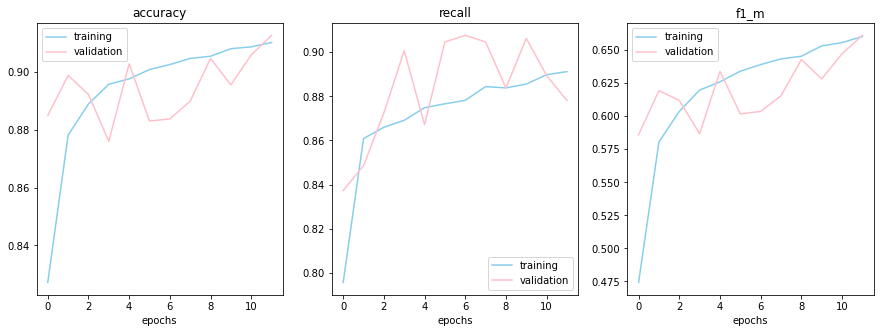

In [39]:
# Grafici koji prikazuju promene metrika tokom treniranja na trening skupu i validacionom skupu kroz epohe 

plot_graphs(binary_history, ['accuracy', 'recall', 'f1_m'])

### 6. Evaluacija modela

Evaluacija se radi i na trening skupu radi praćenja preprilagođavanja, a zatim i na testu

In [62]:
scores = binary_model.evaluate(X_train_transformed, y_train)
print('Loss train: ', scores[0])
print('Train accuracy: ', scores[1])
print('Train precision: ', scores[2])
print('Train recall: ', scores[3])
print('Train auc: ', scores[4])
print('Train F1: ', scores[5])

3743/3743 [==============================] - 10s 3ms/step - loss: 0.2477 - accuracy: 0.9157 - precision: 0.5500 - recall: 0.8882 - auc: 0.9633 - f1_m: 0.6457
Loss train:  0.2477434128522873
Train accuracy:  0.915671706199646
Train precision:  0.5499511361122131
Train recall:  0.8881508111953735
Train auc:  0.963295042514801
Train F1:  0.6456656455993652


In [61]:
scores = binary_model.evaluate(X_test_transformed, y_test)
print('Loss: ', scores[0])
print('Test accuracy: ', scores[1])
print('Test precision: ', scores[2])
print('Test recall: ', scores[2])
print('Test auc: ', scores[4])
print('F1: ', scores[5])

2305/2305 [==============================] - 6s 2ms/step - loss: 0.2537 - accuracy: 0.9126 - precision: 0.5407 - recall: 0.8684 - auc: 0.9561 - f1_m: 0.6302
Loss:  0.2536602020263672
Test accuracy:  0.9125983119010925
Test precision:  0.5406903624534607
Test recall:  0.5406903624534607
Test auc:  0.9560765027999878
F1:  0.6302148103713989


Predviđanje: 

In [42]:
y_predicted = binary_model.predict(X_test_transformed)

In [43]:
# sigmoidna funkcija:

y_labels = [int(score > 0.5) for score in y_predicted]

In [44]:
cf = metrics.confusion_matrix(y_test, y_labels)
print(cf)

[[60857  5469]
 [  976  6438]]


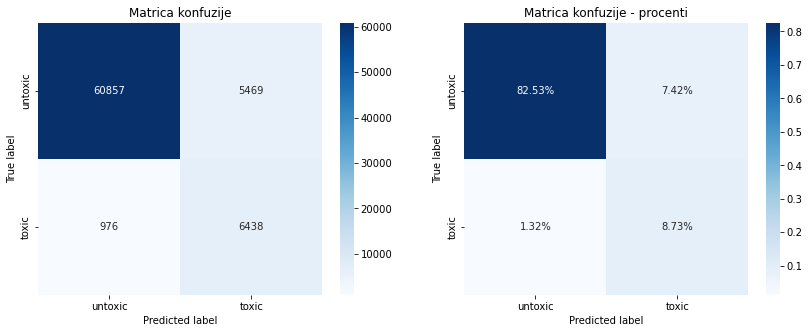

In [45]:
# funkcija koja prikazuje matricu konfuzije i 
# istu tu matricu sa vrednostima u  procentima

plot_cf(cf, 'binary', ['untoxic, toxic'])

#### - Od oko 90% procenata netoksičnih, 82.18% je tačno klasifikovano(TN), a 7.77% netačno(FP)
#### - Od oko 10% procenata toksičnih komentara, 8.79% je tačno klasifikovano(TP), a 1.27% netačno(FN)

In [59]:
print('---------------------- IZVESTAJ -----------------------\n')
print(metrics.classification_report(y_test, y_labels))

---------------------- IZVESTAJ -----------------------

              precision    recall  f1-score   support

           0       0.98      0.92      0.95     66326
           1       0.54      0.87      0.67      7414

    accuracy                           0.91     73740
   macro avg       0.76      0.89      0.81     73740
weighted avg       0.94      0.91      0.92     73740



Cilj je **maksimizovati odziv**, odnosno treba da bude što manji broj lažno negativnih - važnije je da se pronađu toksični komentari. Manja je šteta ako neki netoksičan bude klasifikovan kao toksičan, nego obrnuto. Preciznost za pozitivnu klasu od 0.5 je u ovom slučaju u redu, jer broj lažno pozitivnih je samo mali deo velikog broja instanci negativne klase (netoksičnih komentara).

In [60]:
metrics.accuracy_score(y_test, y_labels)

0.9125983184160564

Izdvajanje instanci na kojima model greši:

In [47]:
joined = pd.concat([X_test, y_test], axis=1)
joined['predicted'] = y_labels

In [48]:
correct = joined[joined['target'] == joined['predicted']]
incorrect = joined[joined['target'] != joined['predicted']]

Primeri pogresno klasifikovanih komentara:

In [49]:
# pogresno klasifikovane instance: 
incorrect.head()

,comment_text,target,predicted
72935,possibly the worst ever adaptation of a comic ...,0,1
83588,hi i am trying to get breasts like yours but ...,0,1
132027,hornswoggle joining club hornswoggle joined ...,1,0
183724,and do you fugure your baiting is somehow more...,0,1
166794,flickrcom here are a random selection of t...,0,1


In [50]:
# FN -> toksicni koji su klasifikovani kao netoksicni
FN = (incorrect['target']==1) & (incorrect['predicted']==0)

# FP -> netoksicni koji su klasifikovani kao toksicni
FP = (incorrect['target']==0) & (incorrect['predicted']==1)

In [51]:
# incorrect[FP]['comment_text'].head()
# incorrect[FN]['comment_text'].tail()

In [52]:
indexes = incorrect[FP].index
random_index = np.random.choice(indexes)

# primer jednog nasumicnog netoksicnog koji je model obelezio kao toksican komentar

print('Primer lažno pozitivne instance: ')
incorrect[FP]['comment_text'][random_index]

Primer lažno pozitivne instance: 


'youre right bbone means fuck it doesnt mean sack'

In [53]:
# primer nasumicnog toksicnog koji je model obelezio kao netoksican
indexes = incorrect[FN].index
random_index = np.random.choice(indexes)

print('Primer lažno negativne instance: ')
incorrect[FN]['comment_text'][random_index]

Primer lažno negativne instance: 


'this is not vandalism if you look at the quoted text from the notice you may remove this message if you i amprove the article or if you otherwise object to deletion of the article for any reason to avoid confusion it helps to explain why you object to the deletion either in the edit summary or on the talk page if this template is removed it should not be replaced it states that i may remove the notice furthermore i did explain on more than one occasion that i was removing the message because mais ouis had failed to provide any explanation as to why it should be deleted and invited them to do so they didnt it also states clearly that if the template is removed it should not be replaced and it was so fuck off'

U direktorijumu **plots and images/prediction_examples/** se nalaze skrinšotovi nekoliko zanimljivih izlaza prethodnih naredbi, 
na osnovu kojih se može zaključiti da model greši u slučaju greški u kucanju, u slučaju kada su reči napisane slovo po slovo sa razmacima između i slično. U slučaju lažno pozitivnih instanci - model predviđa komentar kao toksičan ako ima ružnih reči, a neki takvi komentari su ipak netoksični. Po mom mišljenju, neki od ovih komentara bi trebalo da budu toksični u originalnom skupu. 

Ovakvo ponašanje je očekivano, što znači da model u većini slučajeva dobro zaključuje. 

Ono što se može uraditi za bolja predviđanja je detaljnija priprema teksta, sređivanje komentara sa koji su pogrešno spelovani, spajanje u jednu reč ako ima nekoliko uzastopnih pojedinačnih slova sa razmacima izmeđi i slično.

Proba na novim podacima (kratke rečenice)

In [54]:
# nekoliko jednostavnih provera za uvredljive, obicne komentare, namerno pogresno spelovane...
new_comments = ['fuck you bitch', 
                'fukc you', 
                'hello i have a question about something', 
                'shit head', 
                'shithead',
                'this is a clean comment', 
                'get out of here',
                's h i t',
                'you are so stupid']

new = to_sequence(new_comments, max_len, tokenizer)

In [55]:
# verovatnoce pripadanja toksicnim:

probs = binary_model.predict(new)
toxic_probs = {}
i = 0
for comment in new_comments:
    toxic_probs[comment] = round(probs[i][0], 3)
    i += 1

In [56]:
print('Verovatnoca pripadanja komentara klasi toksicnih: ')
toxic_probs

Verovatnoca pripadanja komentara klasi toksicnih: 


{'fuck you bitch': 0.999,
 'fukc you': 0.573,
 'hello i have a question about something': 0.182,
 'shit head': 0.998,
 'shithead': 0.29,
 'this is a clean comment': 0.213,
 'get out of here': 0.296,
 's h i t': 0.292,
 'you are so stupid': 0.996}

Od ovih primera, model pogrešno predviđa jedino za dva komentara koja su pogrešno napisana, pa se za njih ne može zaključiti da su u pitanju uvredljive reči.

### Čuvanje modela

In [57]:
#binary_model.save_weights('models/binary_model_weights.h5')
#binary_model.save('models/binary_model.h5')

In [58]:
#model = keras.models.load_model('models/binary_model.h5', custom_objects={"f1_m": f1_m})
#utils.plot_model(model, to_file='plots and images/binary_model.png', show_shapes=True)
# model.get_config()